In [1]:
from mlflux.predictor import FluxANNs
from mlflux.eval import open_case
from matplotlib import pyplot as plt
from mlflux.gotm import read2010
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


%load_ext autoreload
%autoreload 3

In [2]:
''' The data set '''

# Path (requires that the ows_papa/ directory exists)
path = 'ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S')

# Interpolate to hourly
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly

# Select a range of dates
sd = '2012-01-01'; ed = '2012-12-30'
# sd = '2012-05-21'; ed = '2012-08-20'
# sd = '2012-08-21'; ed = '2013-01-10'
ds = ds_uniform.sel(datetime=slice(sd,ed))

ds = ds.resample(datetime='3H').mean() # Coarsening to 3-hourly

''' These are artificially assigned, for models that use these features. '''
ds['zu'] = 10*ds['U']/ds['U']
ds['zt'] = 10*ds['U']/ds['U']
ds['zq'] = 10*ds['U']/ds['U']
ds = ds.rename({'t': 'tair', 'sst': 'tsea', 'q':'qair'})

In [3]:
ds

<xarray.Dataset>
Dimensions:   (datetime: 2920)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2012-01-01 ... 2012-12-30T21:00:00
Data variables: (12/18)
    tsea      (datetime) float64 6.588 6.593 6.584 6.582 ... 5.492 5.488 5.493
    ux        (datetime) float64 6.329 2.004 -0.5152 1.423 ... 5.241 2.02 2.354
    uy        (datetime) float64 -1.742 -5.632 -8.467 ... 7.079 7.575 9.552
    tair      (datetime) float64 4.804 4.773 5.008 5.107 ... 6.131 6.058 6.21
    p         (datetime) float64 9.891e+04 9.885e+04 ... 1.002e+05 1.004e+05
    qair      (datetime) float64 0.00457 0.004589 0.004768 ... 0.005361 0.005426
    ...        ...
    rh        (datetime) float64 83.88 84.35 85.99 89.04 ... 89.1 91.31 91.63
    cos       (datetime) float64 0.9483 0.3285 -0.06174 ... 0.592 0.2614 0.2376
    sin       (datetime) float64 -0.2767 -0.9047 -0.9978 ... 0.8027 0.961 0.9698
    zu        (datetime) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
    zt        (datetime) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
    zq        (datetime) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0

In [3]:
import torch

def Q (ds, model_SH, model_LH):
    input_keys = model_SH.config['ikeys']
    X = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))    
    mean = model_SH.pred_mean(X).detach().numpy().squeeze()
    std =  model_SH.pred_var(X).detach().numpy().squeeze() ** 0.5
    ds['qh_ann'] = mean*ds.Q/ds.Q
    ds['qh_std'] = std*ds.Q/ds.Q

    input_keys = model_LH.config['ikeys']
    X = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
    mean = model_LH.pred_mean(X).detach().numpy().squeeze()
    std =  model_LH.pred_var(X).detach().numpy().squeeze() ** 0.5
    ds['ql_ann'] = mean*ds.Q/ds.Q
    ds['ql_std'] = std*ds.Q/ds.Q
    
    ds['Qt_ann'] = ds.qh_ann + ds.ql_ann
    # This is without consideration of covariance
    ds['Qt_std'] = (ds['qh_std']**2 + ds['ql_std']**2) ** 0.5
    return ds

### Plot time series

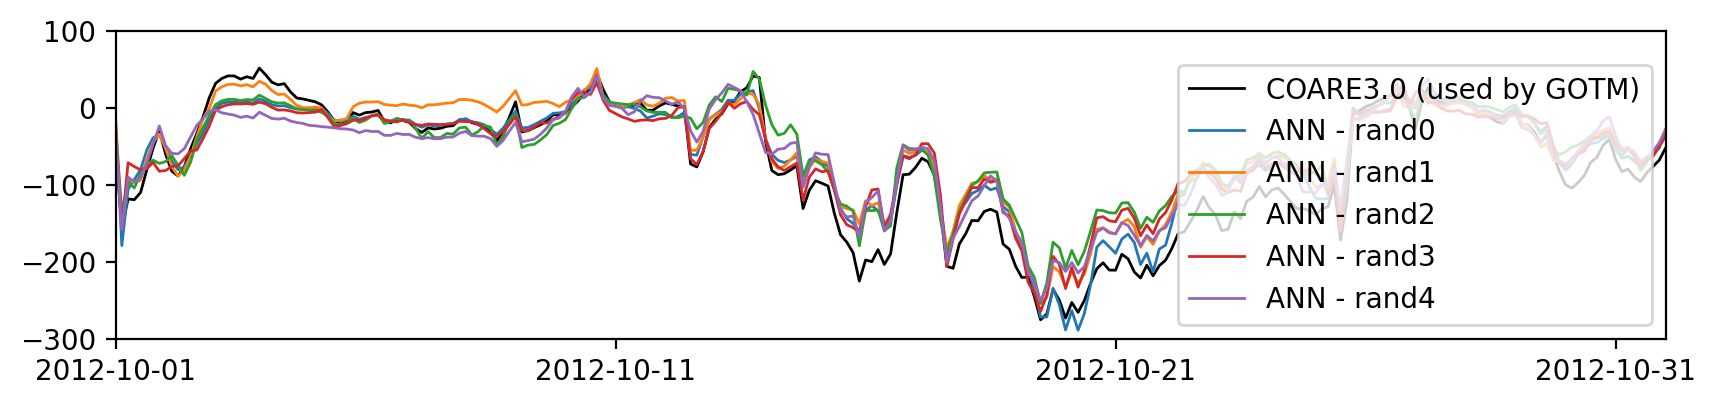

In [31]:
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

###### Bulk 
plt.plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0 (used by GOTM)', c='k', lw=1) 

###### ANNs
# SHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# LHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
LHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
# SHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/SH4_1/tr2/'
# LHmodel_dir = f'/home/jw8736/mlflux/saved_model/final/LH4_1/tr2/'

for rand in range(5):
    model_name = 'model_rand%g.p' %rand
    SHmodel = open_case (SHmodel_dir, model_name)  
    LHmodel = open_case (LHmodel_dir, model_name)
    ds = Q(ds, SHmodel, LHmodel)
    ds['Qt_ann'] = ds['qh_ann'] + ds['ql_ann']
    plt.plot(ds.datetime, ds.Qt_ann, label='ANN - rand%g' %rand,  lw=1) 

plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.legend(loc='lower right')
plt.ylim([-300, 100]);

### With uncertainty envelop

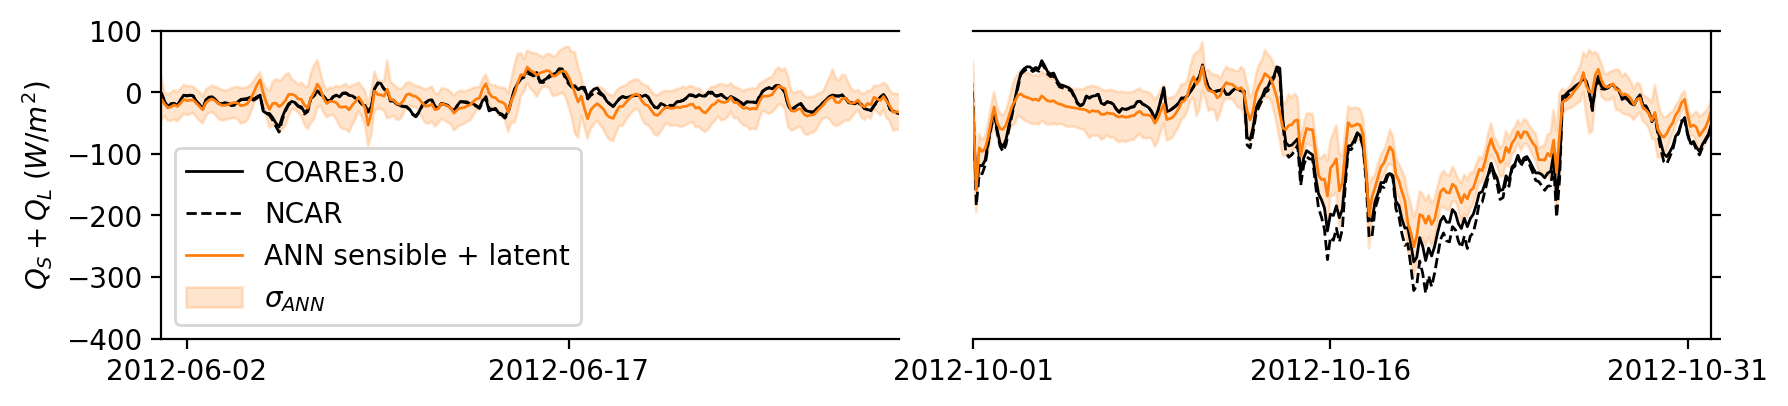

In [27]:
# computed from ANNs
from aerobulk.flux import noskin_np
fig, axes = plt.subplots(1, 2, figsize=[10,2], dpi=200, sharey=True)
plt.subplots_adjust(wspace=0.1)

###### Bulk 
axes[0].plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0', c='k', lw=1)
axes[1].plot(ds.datetime, ds.Q - ds.lwr, c='k', lw=1) 
ds_ = ds
ql, qh, taux, tauy, evap = \
noskin_np(sst=ds_.tsea.to_numpy()+273.15, t_zt=ds_.tair.to_numpy()+273.15, 
       hum_zt=ds_.qair.to_numpy(), u_zu=ds_.ux.to_numpy(), 
       v_zu=ds_.uy.to_numpy(), slp=ds_.p.to_numpy(), 
       algo='ncar', zt=2., zu=10.,
       niter=6, input_range_check=True)
axes[0].plot(ds_.datetime, qh + ql, '--', label='NCAR', c='k', lw=1)
axes[1].plot(ds_.datetime, qh + ql, '--', c='k', lw=1)


###### ANNs
SHmodel_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
LHmodel_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

rand = 4 # choose one
model_name = 'model_rand%g.p' %rand
SHmodel = open_case (SHmodel_dir, model_name)  
LHmodel = open_case (LHmodel_dir, model_name)
ds = Q(ds, SHmodel, LHmodel)

ds['Qt_ann'] = ds['qh_ann'] + ds['ql_ann']
ds['Qt_std'] = (ds['qh_std']**2 + ds['ql_std']**2)**0.5

axes[0].plot(ds.datetime, ds['Qt_ann'], label='ANN sensible + latent', color='C1', lw=1)
axes[1].plot(ds.datetime, ds['Qt_ann'], color='C1', lw=1)

axes[0].fill_between(ds.datetime, ds['Qt_ann'] - ds['Qt_std'], ds['Qt_ann'] + ds['Qt_std'], 
                 color='C1', alpha=0.2, label='$\sigma_{ANN}$')
axes[1].fill_between(ds.datetime, ds['Qt_ann'] - ds['Qt_std'], ds['Qt_ann'] + ds['Qt_std'], 
                 color='C1', alpha=0.2)

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
# plot the same data on both Axes
# zoom-in / limit the view to different portions of the data
axes[0].set_xlim([pd.Timestamp('2012-06-01'), pd.Timestamp('2012-06-30')])
axes[1].set_xlim([pd.Timestamp('2012-10-01'), pd.Timestamp('2012-11-01')])

# # hide the spines between ax and ax2
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].yaxis.tick_left()
# axes[0].tick_params(labelright='off')  # don't put tick labels at the top
# axes[1].tick_params(labelleft='off')  # don't put tick labels at the top
axes[1].yaxis.tick_right()

axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=15))
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=15))

axes[0].legend(loc='lower left')
axes[0].set_ylim([-400, 100]);
axes[0].set_ylabel(r'$Q_S+Q_L \; (W/m^2)$')
fig.savefig(f'../plots/OWS.png', bbox_inches='tight')

### Attributing difference with Bulk

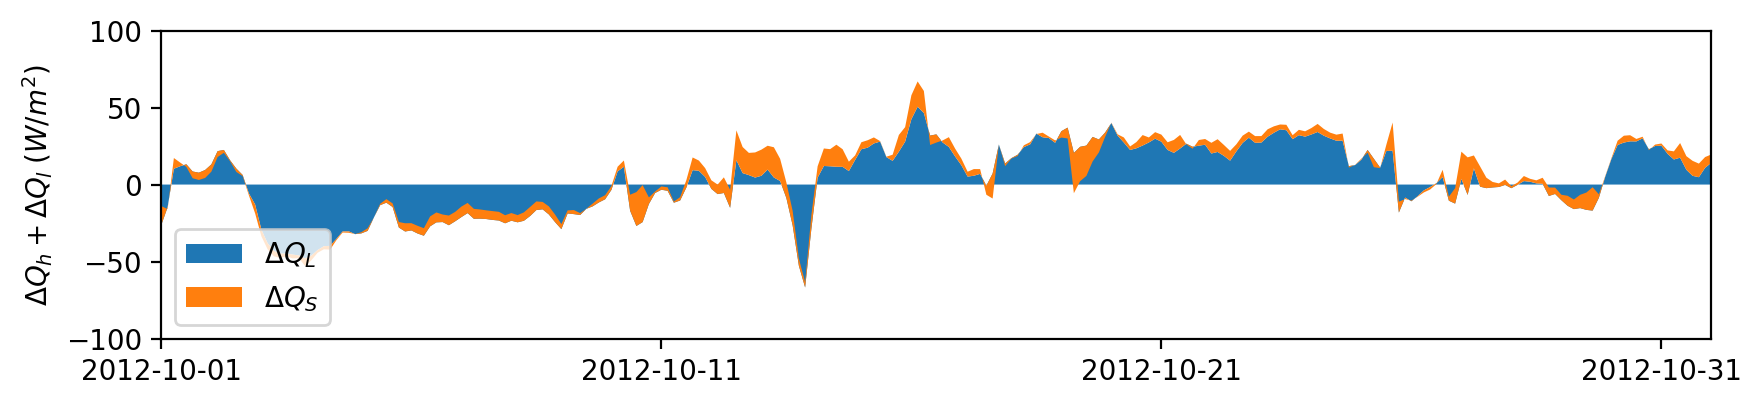

In [33]:
''' Heat flux difference decomposed '''

# computed bulk 
from aerobulk.flux import noskin_np
ql, qh, taux, tauy, evap = \
noskin_np(sst=ds.tsea.to_numpy()+273.15, t_zt=ds.tair.to_numpy()+273.15, 
       hum_zt=ds.qair.to_numpy(), u_zu=ds.ux.to_numpy(), 
       v_zu=ds.uy.to_numpy(), slp=ds.p.to_numpy(), 
       algo='coare3p0', zt=10., zu=10., niter=6, input_range_check=True)
# Sanity check that COARE3p0 is what GOTM uses
# plt.plot(ds.datetime, qh + ql, '--', label='COARE3p0', c='g', lw=1)
# plt.plot(ds.datetime, ds.Q - ds.lwr, '--', label='COARE3p0', c='g', lw=1)

fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()
y1 = ds.qh_ann - qh
y2 = ds.ql_ann - ql
plt.stackplot(ds.datetime, y2, y1, labels=['$\Delta Q_L$','$\Delta Q_S$'])
plt.legend(loc='lower left')
plt.ylabel('$\Delta Q_h + \Delta Q_l \; (W/m^2)$')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])
plt.ylim([-100, 100]);

(15614.0, 15645.0)

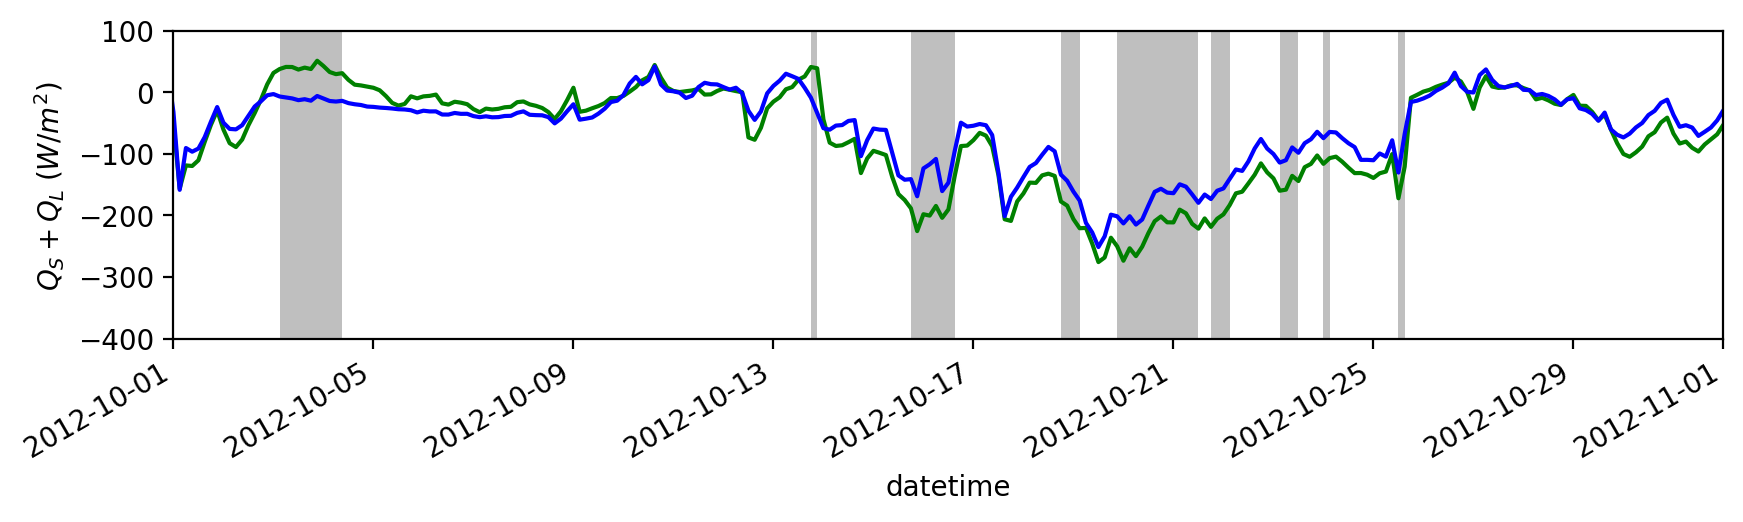

In [34]:
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

def plot_fill (ax, ds):
    # cond = abs(ds.Q - ds.lwr - ds.Qt_ann) / abs(ds.Q - ds.lwr + 0.0000001) > 1
    cond = abs(ds.Q - ds.lwr - ds.Qt_ann) > 40
    ds_far = ds.where(cond)
    (ds.Q-ds.lwr).plot(label='Bulk', c='g')
    ds.Qt_ann.plot(label='ANN', c='b')
    ax.set_ylim([-400,100]); ax.set_ylabel('$Q_S+Q_L\; (W/m^2)$ ')
    ax.fill_between(ds.datetime, -400, 100, where=cond, color='gray', alpha=0.5, edgecolor='None')

plot_fill (ax, ds)
plt.xlim([pd.Timestamp('2012-10-01'),pd.Timestamp('2012-11-01')])

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


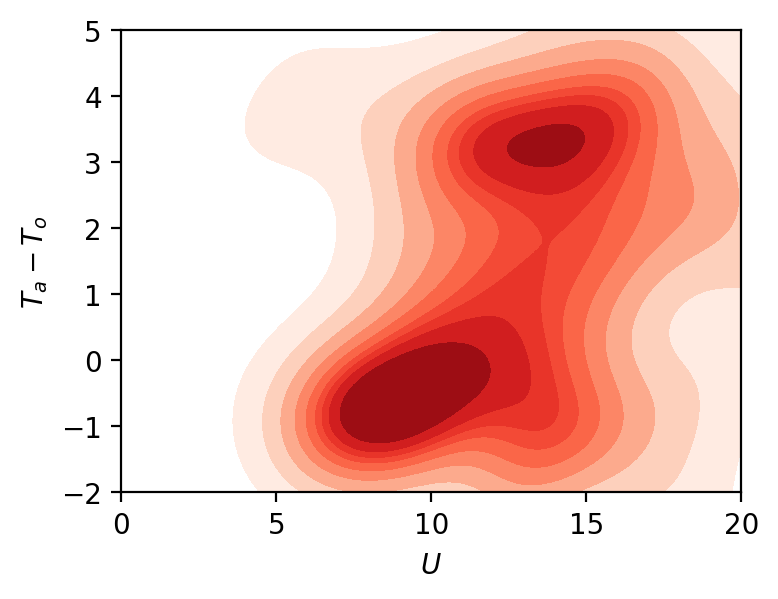

In [35]:
import seaborn as sns
fig = plt.figure(figsize=[4,3], dpi=200); ax = plt.gca()

cond = abs(ds.Q - ds.lwr - ds.Qt_ann) > 40
ds_far = ds.where(cond)

# sns.set_style("white")
sns.kdeplot(x=ds_far.U, y=ds_far.tsea-ds_far.tair, cmap="Reds", fill=True, ax=ax)
ax.set_xlabel('$U$'); ax.set_ylabel('$T_a-T_o$')
ax.set_xlim([0,20]); ax.set_ylim([-2,5]); plt.show()

### Generating sequences and write to file
This can also be done by running the script.

In [6]:
import argparse
import os
import xarray as xr
import numpy as np
from mlflux.gotm import read2010, predict, gen_epsilon_flux, write_stoch_flux

# REMEMBER TO CHANGE ACCORDINGLY
SHmodel_dir = '/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
LHmodel_dir = '/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
Mmodel_dir = '/home/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
rand = 4

In [11]:
# Path
input_folder = '/home/jw8736/code-5.2.1/cases/ows_papa/'
output_folder = '/scratch/jw8736/gotm/ensem/'

# Read and interpolate to hourly and then coarsen according to dt
df = read2010(input_folder, datetimeformat='%Y-%m-%d %H:%M:%S')    
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly
ds = ds_uniform.sel(datetime=slice('2012-01-01','2012-03-01'))

dt_str = str(int(1)) + 'H' 
ds = ds.resample(datetime=dt_str).mean() 

# These are artificially assigned, for models that use these features
ds['zu'] = 10*ds['U']/ds['U']
ds['zt'] = 10*ds['U']/ds['U']
ds['zq'] = 10*ds['U']/ds['U']
ds = ds.rename({'t': 'tair', 'sst': 'tsea', 'q':'qair'})

# Predict by ANNs 
from mlflux.predictor import FluxANNs
ds = predict(ds, SHmodel_dir, LHmodel_dir, Mmodel_dir, rand)

Predicting fluxes and stds based on ANNs in 
 SH directory /home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/
 LH directory /home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/
 M directory /home/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/ ...
Finished!


In [7]:
ds

<xarray.Dataset>
Dimensions:   (datetime: 2920)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2012-01-01 ... 2012-12-30T21:00:00
Data variables: (12/24)
    tsea      (datetime) float64 6.588 6.593 6.584 6.582 ... 5.492 5.488 5.493
    ux        (datetime) float64 6.329 2.004 -0.5152 1.423 ... 5.241 2.02 2.354
    uy        (datetime) float64 -1.742 -5.632 -8.467 ... 7.079 7.575 9.552
    tair      (datetime) float64 4.804 4.773 5.008 5.107 ... 6.131 6.058 6.21
    p         (datetime) float64 9.891e+04 9.885e+04 ... 1.002e+05 1.004e+05
    qair      (datetime) float64 0.00457 0.004589 0.004768 ... 0.005361 0.005426
    ...        ...
    qh_ann    (datetime) float64 -19.14 -18.59 -19.99 ... 8.947 8.074 20.21
    qh_std    (datetime) float64 10.69 11.14 9.781 9.595 ... 9.812 10.22 14.71
    ql_ann    (datetime) float64 -17.34 -12.26 -42.56 ... -7.675 -6.891 -7.128
    ql_std    (datetime) float64 21.78 21.68 27.65 33.05 ... 18.73 16.5 20.31
    Qt_ann    (datetime) float64 -36.48 -30.85 -62.55 ... 1.272 1.183 13.08
    Qt_std    (datetime) float64 24.27 24.38 29.33 34.42 ... 21.15 19.41 25.07

In [23]:
ENSEM = 4
np.random.seed(0)
Q_eps_ensem = gen_epsilon_flux (ds, FLUX='heat', T=60, dt=1, ENSEM=ENSEM)
mean = (ds.qh_ann.values + ds.ql_ann.values + ds.lwr.values).reshape(-1, 1)
# output_path = '/scratch/jw8736/gotm/ensem/2012-01-01_2020-01-01/'
# eps_ensem = Q_eps_ensem.reshape(4, -1, 1) # of shape ensem*time*number_of_quantities_per_row
# bulk = ds.Q.values.reshape(-1,1) 
# write_stoch_flux (path=output_path, datetime=ds.datetime.values,
#                   mean=mean, eps_ensem=eps_ensem, bulk=bulk, prefix='heatflux_')

Generating an ensemble of heat flux. Size=4.
Finished! eps_ensem array shape: (4, 2920)


In [24]:
def write_datetime (output_file, datetime, values):
    ''' output_file: output file path
        datatime: object of pandas datetime format
        values: a value array to write '''
    # Write the datetime and values to the file, row by row
    with open(output_file, 'w') as file:
        for t, val_row in zip(datetime, values):
            datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
            values_string = '\t'.join(f"{val:.8f}" for val in val_row)
            file.write(f"{datetime_string}\t{values_string}\n")
    print('Finish writing to ' + output_file)

### Plot stochastic members 

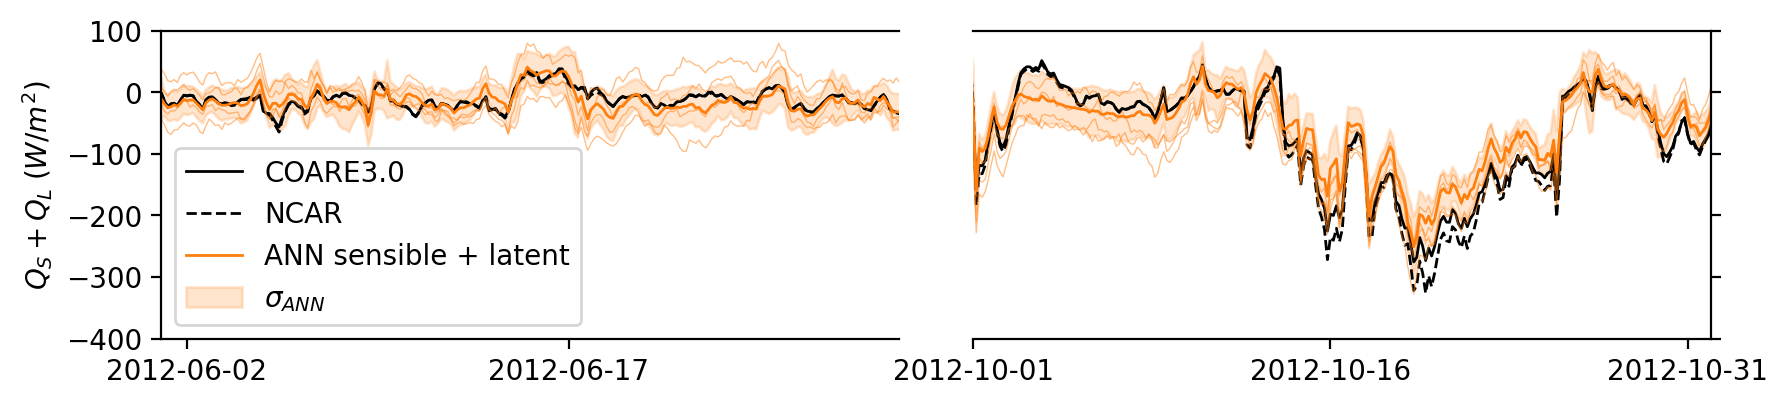

In [26]:
# computed from ANNs
from aerobulk.flux import noskin_np
fig, axes = plt.subplots(1, 2, figsize=[10,2], dpi=200, sharey=True)
plt.subplots_adjust(wspace=0.1)

###### Bulk 
axes[0].plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0', c='k', lw=1)
axes[1].plot(ds.datetime, ds.Q - ds.lwr, c='k', lw=1) 
ds_ = ds
ql, qh, taux, tauy, evap = \
noskin_np(sst=ds_.tsea.to_numpy()+273.15, t_zt=ds_.tair.to_numpy()+273.15, 
       hum_zt=ds_.qair.to_numpy(), u_zu=ds_.ux.to_numpy(), 
       v_zu=ds_.uy.to_numpy(), slp=ds_.p.to_numpy(), 
       algo='ncar', zt=2., zu=10.,
       niter=6, input_range_check=True)
axes[0].plot(ds_.datetime, qh + ql, '--', label='NCAR', c='k', lw=1)
axes[1].plot(ds_.datetime, qh + ql, '--', c='k', lw=1)


###### ANNs
SHmodel_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
LHmodel_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

rand = 4 # choose one
model_name = 'model_rand%g.p' %rand
SHmodel = open_case (SHmodel_dir, model_name)  
LHmodel = open_case (LHmodel_dir, model_name)
ds = Q(ds, SHmodel, LHmodel)

ds['Qt_ann'] = ds['qh_ann'] + ds['ql_ann']
ds['Qt_std'] = (ds['qh_std']**2 + ds['ql_std']**2)**0.5

axes[0].plot(ds.datetime, ds['Qt_ann'], label='ANN sensible + latent', color='C1', lw=1)
axes[1].plot(ds.datetime, ds['Qt_ann'], color='C1', lw=1)

axes[0].fill_between(ds.datetime, ds['Qt_ann'] - ds['Qt_std'], ds['Qt_ann'] + ds['Qt_std'], 
                 color='C1', alpha=0.2, label='$\sigma_{ANN}$')
axes[1].fill_between(ds.datetime, ds['Qt_ann'] - ds['Qt_std'], ds['Qt_ann'] + ds['Qt_std'], 
                 color='C1', alpha=0.2)

for i in range(0,ENSEM):
    axes[0].plot(ds.datetime, ds['Qt_ann'] + Q_eps_ensem[i], lw=0.5, alpha=0.5, c='C1')
    axes[1].plot(ds.datetime, ds['Qt_ann'] + Q_eps_ensem[i], lw=0.5, alpha=0.5, c='C1')

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
# plot the same data on both Axes
# zoom-in / limit the view to different portions of the data
axes[0].set_xlim([pd.Timestamp('2012-06-01'), pd.Timestamp('2012-06-30')])
axes[1].set_xlim([pd.Timestamp('2012-10-01'), pd.Timestamp('2012-11-01')])

# # hide the spines between ax and ax2
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].yaxis.tick_left()
# axes[0].tick_params(labelright='off')  # don't put tick labels at the top
# axes[1].tick_params(labelleft='off')  # don't put tick labels at the top
axes[1].yaxis.tick_right()

axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=15))
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=15))

axes[0].legend(loc='lower left')
axes[0].set_ylim([-400, 100]);
axes[0].set_ylabel(r'$Q_S+Q_L \; (W/m^2)$')
fig.savefig(f'../plots/OWS_stochastic.png', bbox_inches='tight')